# Plot Cosmosis Chains
it just plots the trace

In [6]:
pwd

'/Users/aa3044/Documents/GitHub/CUDA_Programming/project'

In [23]:
import pandas as pd

def read_cosmosis_chain(filename):
    header = []
    # Read only the header line
    with open(filename, 'r') as f:
        for line in f:
            if not line.startswith('#'):
                break
            else:
                header.append(line)
    raw_names = header[0].strip('#').strip().split('\t')
    clean_names = [name.split('--')[-1] for name in raw_names]

    # Load the actual data
    df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)
    df.columns = clean_names
    return df

# Usage
#chain_file = '/its/home/aa3044/CUDA_course/CUDA_Programming/project/outputs/gpu/test_per_bin_pygpu.txt'
chain_file = '/Users/aa3044/Documents/GitHub/CUDA_Programming/project/outputs/test_per_bin_pygpu3.txt'
#chain_file = '/Users/aa3044/Documents/GitHub/CUDA_Programming/project/outputs/test_per_bin-2.txt'
#chain_file = '/global/u2/a/arwa_mq/DESy3/Boost_Factor/outputs/test_per_bin.txt'
#chain_file00 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc00.txt'
#chain_file10 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc10.txt' 
#chain_file20 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc20.txt' 
#chain_file30 = '/Users/aa3044/Documents/GitHub/DESy3/Boost_Factor/data/test_per_binc30.txt'  
#test_per_bin00for_plot.txt'
df00 = read_cosmosis_chain(chain_file)
#df10 = read_cosmosis_chain(chain_file10)
#df20 = read_cosmosis_chain(chain_file20)
#df30 = read_cosmosis_chain(chain_file30)

/var/folders/6j/1zd9ncd53d768vh6bskpy7tc0000gp/T/ipykernel_48555/125026434.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, comment='#', delim_whitespace=True, header=None)


In [24]:
# df = df.drop(columns='prior')
df00

,logrs_00,logb0_00,prior,post
0,0.000888,-0.004188,-1.386294,-100737.467224
1,0.001339,0.000064,-1.386294,-103364.213865
2,0.001144,-0.005175,-1.386294,-100248.324688
3,0.000130,0.002147,-1.386294,-104212.067645
4,0.001020,-0.001709,-1.386294,-102219.987398
...,...,...,...,...
19995,-0.262556,-0.552038,-1.386294,-2.409272
19996,-0.330303,-0.497001,-1.386294,-2.747452
19997,-0.304251,-0.514723,-1.386294,-2.540181
19998,-0.331786,-0.503039,-1.386294,-1.986502


In [ ]:
#

In [ ]:
#

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_trace(df, burnin=0.0, external_means=None):
    """
    Plot trace plots with:
    - Horizontal lines at sample mean (red dashed)
    - Optional reference values from other work (black dashed)

    Parameters:
    - df: pandas DataFrame with samples, may include 'post'.
    - burnin: fraction of samples to discard.
    - external_means: dict of {param_name: (mean, sigma)} in linear scale.

    Returns:
    - fig: matplotlib figure.
    """
    # Drop 'post' column and clean
    df_params = df.drop(columns='prior') if 'prior' in df.columns else df.copy()
    df_params = df_params.replace([np.inf, -np.inf], np.nan).dropna()

    # Convert log columns to linear
    trace_df = df_params.copy()
    new_names = []
    for col in trace_df.columns:
        if col.startswith("log"):
            trace_df[col] = 10**trace_df[col]
            new_names.append(col[3:])
        else:
            new_names.append(col)
    trace_df.columns = new_names

    # Apply burn-in
    if burnin > 0.0:
        n = int(len(trace_df) * burnin)
        trace_df = trace_df.iloc[n:]

    # Plot setup
    n_params = len(trace_df.columns)
    fig, axes = plt.subplots(n_params, 1, figsize=(10, 2.5 * n_params), sharex=True)
    if n_params == 1:
        axes = [axes]

    for i, col in enumerate(trace_df.columns):
        data = trace_df[col].values
        sample_mean = data.mean()

        axes[i].plot(data, lw=0.7, alpha=0.8)
        axes[i].axhline(sample_mean, color='r', linestyle='--', label=f'sample mean = {sample_mean:.3g}')

        if external_means and col in external_means:
            ref_mean, ref_sigma = external_means[col]
            axes[i].axhline(ref_mean, color='k', linestyle='--', label=f'ref = {ref_mean:.2f}')
            axes[i].fill_between(
                np.arange(len(data)),
                ref_mean - ref_sigma,
                ref_mean + ref_sigma,
                color='gray',
                alpha=0.2,
                label='±1σ ref'
            )

        axes[i].set_ylabel(col)
        axes[i].legend()
        axes[i].grid(True)

    axes[-1].set_xlabel("Sample index")
    fig.suptitle("Trace Plots with Sample Mean and External Reference", fontsize=15)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    return fig


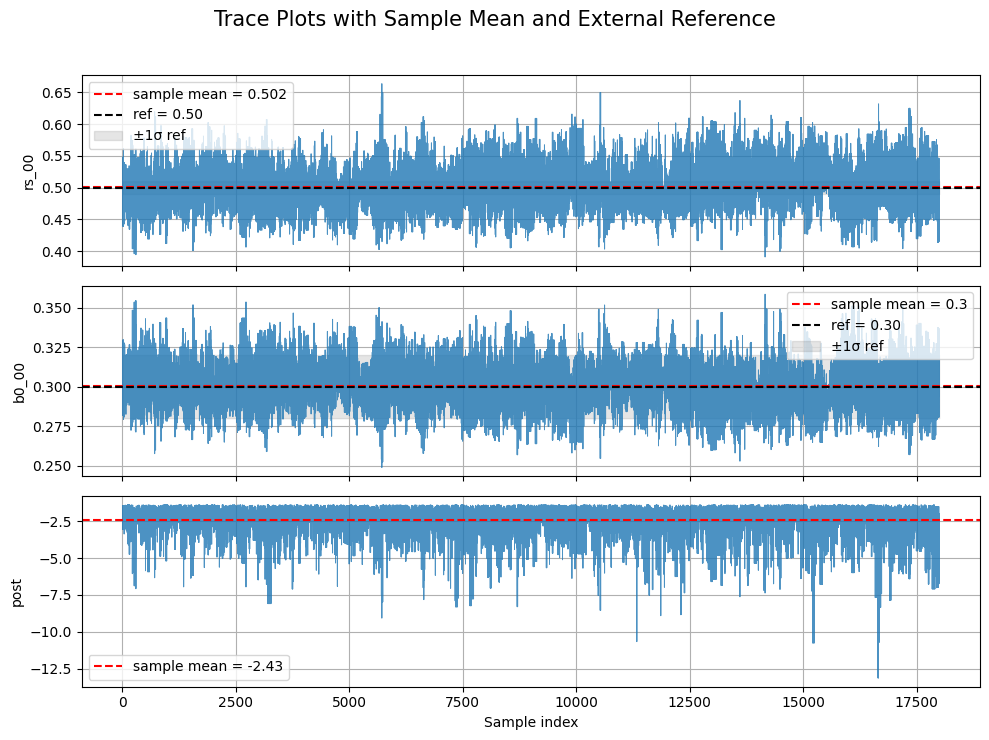

In [25]:
external_means = {
    'b0_00': (0.3, 0.02),
    'rs_00': (0.5, 0.01)
}

fig = plot_trace(df00, burnin=0.1, external_means=external_means)
plt.show()